In [9]:
# reload modules if they are changed
%load_ext autoreload
%autoreload 2

# A lot of methods are moved to separate submodules to make this notebook cleaner and easier to understand
# Add the current folder to your PATH so you can import them
import os
os.sys.path.insert(0, "/gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/project_specific_ipynb_code/bottleneck_project") # so VScode know to look here for modules
import data_helper_functions
import helper_functions

import model_data_base
import Interface as I

print("Cuda is available: "+str(helper_functions.torch.cuda.is_available()))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Cuda is available: True


In [5]:
# ip adress of running node -> change this accordingly
ip = "10.102.3.86"

In [10]:
data_helper_functions.register_databases(ip)  # change this IP every time

registering database with unique_id 2022-08-29_117057_mvi4MLC to the absolute path /gpfs/soma_fs/scratch/abast/results/20220829_hot_zone_on_demand_simulations
registering database with unique_id 2022-08-29_139830_1aB8K0e to the absolute path /gpfs/soma_fs/scratch/abast/results/20220829_hot_zone_on_demand_simulations/mdbs_qr8fqtte_/mdb
registering database with unique_id 2022-09-07_148835_MCLAx5Q to the absolute path /gpfs/soma_fs/scratch/abast/results/20220829_hot_zone_on_demand_simulations/mdbs_qr8fqtte_/mdb/example_in_distribution_simulation_1ms_inh_adapt_i_i2melyug_/mdb
registering database with unique_id 2022-09-16_72225_QtIPT5M to the absolute path /gpfs/soma_fs/scratch/abast/results/20220829_hot_zone_on_demand_simulations/mdbs_qr8fqtte_/mdb/example_in_distribution_simulation_1ms_inh_adapt_i_i2melyug_/mdb/reduced_ann_models5_9gopetp1_/mdb


In [11]:
client = I.distributed.Client(ip+':38786')  # this adress changes depending on which node you're using
client

Client Scheduler: tcp://10.102.3.86:38786 Dashboard: http://10.102.3.86:38787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [12]:
# init mdb for which batches should be generated
mdb = I.ModelDataBase('/gpfs/soma_fs/scratch/abast/results/20220829_hot_zone_on_demand_simulations/')
mdb._register_this_database()
mdb = mdb['mdbs']
mdb._register_this_database()
mdb = mdb['example_in_distribution_simulation_1ms_INH_adapt_inh_v2.6_shift-3_offset_445_280000_trials']
mdb._register_this_database()
mdb_models = mdb['reduced_ANN_models5']
mdb_models._register_this_database()

batches_dir = mdb[('synapse_activation_binned_v2', '365_505_1', 'EI__section/branch_bin')]

registering database with unique_id 2022-08-29_117057_mvi4MLC to the absolute path /gpfs/soma_fs/scratch/abast/results/20220829_hot_zone_on_demand_simulations
registering database with unique_id 2022-08-29_139830_1aB8K0e to the absolute path /gpfs/soma_fs/scratch/abast/results/20220829_hot_zone_on_demand_simulations/mdbs_qr8fqtte_/mdb
registering database with unique_id 2022-09-07_148835_MCLAx5Q to the absolute path /gpfs/soma_fs/scratch/abast/results/20220829_hot_zone_on_demand_simulations/mdbs_qr8fqtte_/mdb/example_in_distribution_simulation_1ms_inh_adapt_i_i2melyug_/mdb
registering database with unique_id 2022-09-16_72225_QtIPT5M to the absolute path /gpfs/soma_fs/scratch/abast/results/20220829_hot_zone_on_demand_simulations/mdbs_qr8fqtte_/mdb/example_in_distribution_simulation_1ms_inh_adapt_i_i2melyug_/mdb/reduced_ann_models5_9gopetp1_/mdb


# Visualizing the weights fo the encoder (first layer)

This sections concerns itself with making visualisations of the first layer of the bottleneck layer. This layer projects the total synaptic input onto one or more bottleneck nodes that then represent an aggregated synaptic input. Which parts of the neuron are important, and when they become important, can be visualised here.

Some models have 1 bottleneck layer, and some have 2. You should check for yourself if there are 2 bottleneck nodes available (by inspecting `model.to_cpu()`) and visualise the one you want by specifying the `bottleneck_node` argument when initialising a `WeightPlot` instance. Trying to plot a second bottleneck node for a model that only has one will simply yield an out-of-bounds error.

Keep in mind that some models have "flipped" weights. Sometimes excitatory input gets associated positive weights and inhibitory negative ones, sometimes it's vice-versa. Which one of the two it'll be is randomly determined at the initialisation time of the ANN. The important aspect is that they have opposite signs.

In [58]:
import matplotlib as mpl
from viz import WeightPlot
COLOR = 'black'  # for light themes, put white for dark
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

## Setup mdbs with bottleneck models

In [16]:
model_data_base.mdbopen.resolve_mdb_path('mdb://2022-08-29_117057_mvi4MLC/morphologies/WR64_Cell8/recSites.landmarkAscii')
mdb_dinuka = I.ModelDataBase('/gpfs/soma_fs/scratch/jayalath/mdb_dinuka/300_epoch_retrain')
mdb_models_dinuka = mdb_dinuka['retrain_test_5_times_300_epochs']
mdb_models_arco = mdb['reduced_ANN_models5']
model_dinuka = 'loss_sAP__bn_1__ISIsd__width_min_max_80_0_60__decoder_5x40__L2_0.001_L1_0_TV_0.001__epochs_300__batches_200__ntrials_280000__traintest_260000_20000__CTY70'
model_arco = 'loss_sAP__bn_1__ISIsd__width_min_max_80_0_60__decoder_5x40__L2_0.001_L1_0_TV_0.001__epochs_300__batches_200__ntrials_280000__traintest_260000_20000__1HOE2'
model_arco_2layer = "loss_sAP_dAP__bn_2__ISIsd__width_min_max_80_0_60__decoder_5x40__L2_0.001_L1_0_TV_0.001__epochs_300__batches_200__ntrials_280000__traintest_260000_20000__MD4TW"

## Define global parameters

These parameters define how to reshape the first layer of the bottleneck ANN, where the neuron parameter file is (so it can get visualised along with the weights), and some additional variables that should be the same for all simulations and training sessions that are considered here.

In [59]:
# define params to visualize the weights
weight_reshape_params={
    "n_celltypes": 2,
    "n_spatial_bins": 260,
    "temporal_window_width": 80,
    "weight_scaling": 1
}

neuron_param_file = helper_functions.get_neuron_param_file(mdb)

show_bins = False
bottleneck_size = 1
celltype = 0 # EXC or INH in the plot
ts = range(weight_reshape_params["temporal_window_width"])
t = 70  # time to plot

## Dinukas model

Building cell from neuron parameter file


<Figure size 720x360 with 0 Axes>

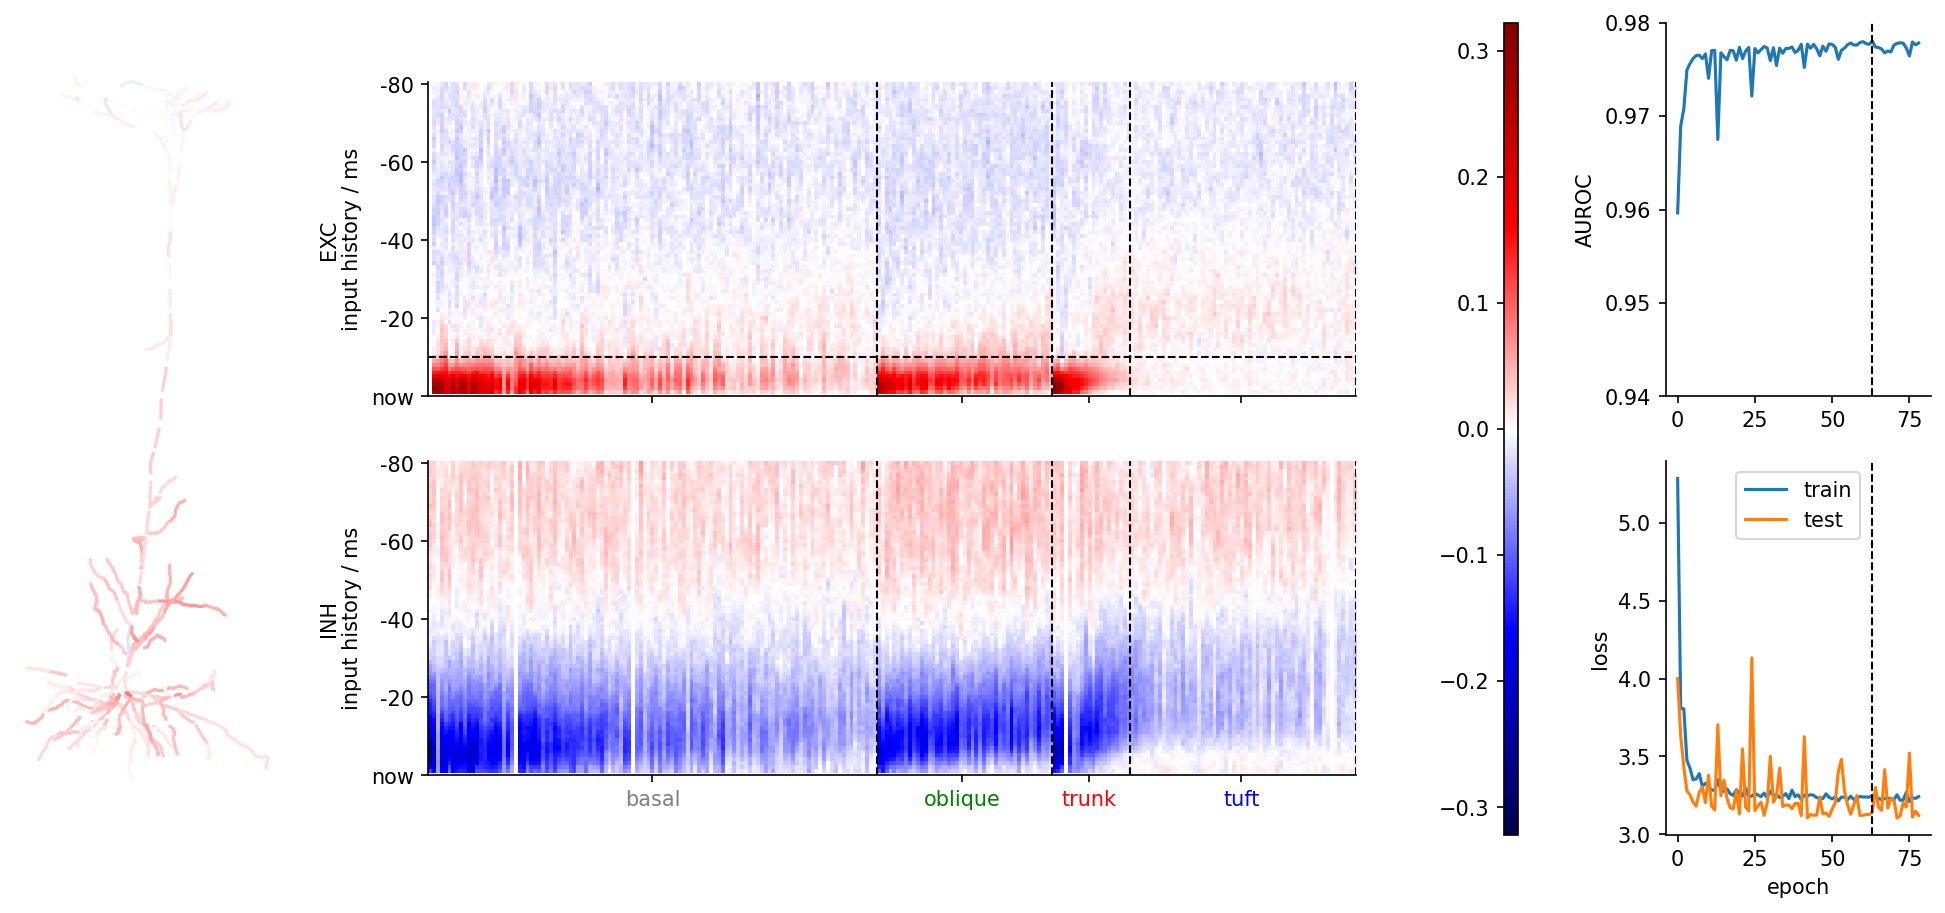

In [60]:
WP = WeightPlot(neuron_param_file, mdb_models_dinuka, model_dinuka, bottleneck_node=0)
I.plt.figure(figsize = (10,5))
axes = WP.plot_weights(categories=False, celltype=celltype, t=t, **weight_reshape_params)
I.plt.show()

## Arco's model: plot some epoch (64) at some time t = 79

Building cell from neuron parameter file


<Figure size 720x360 with 0 Axes>

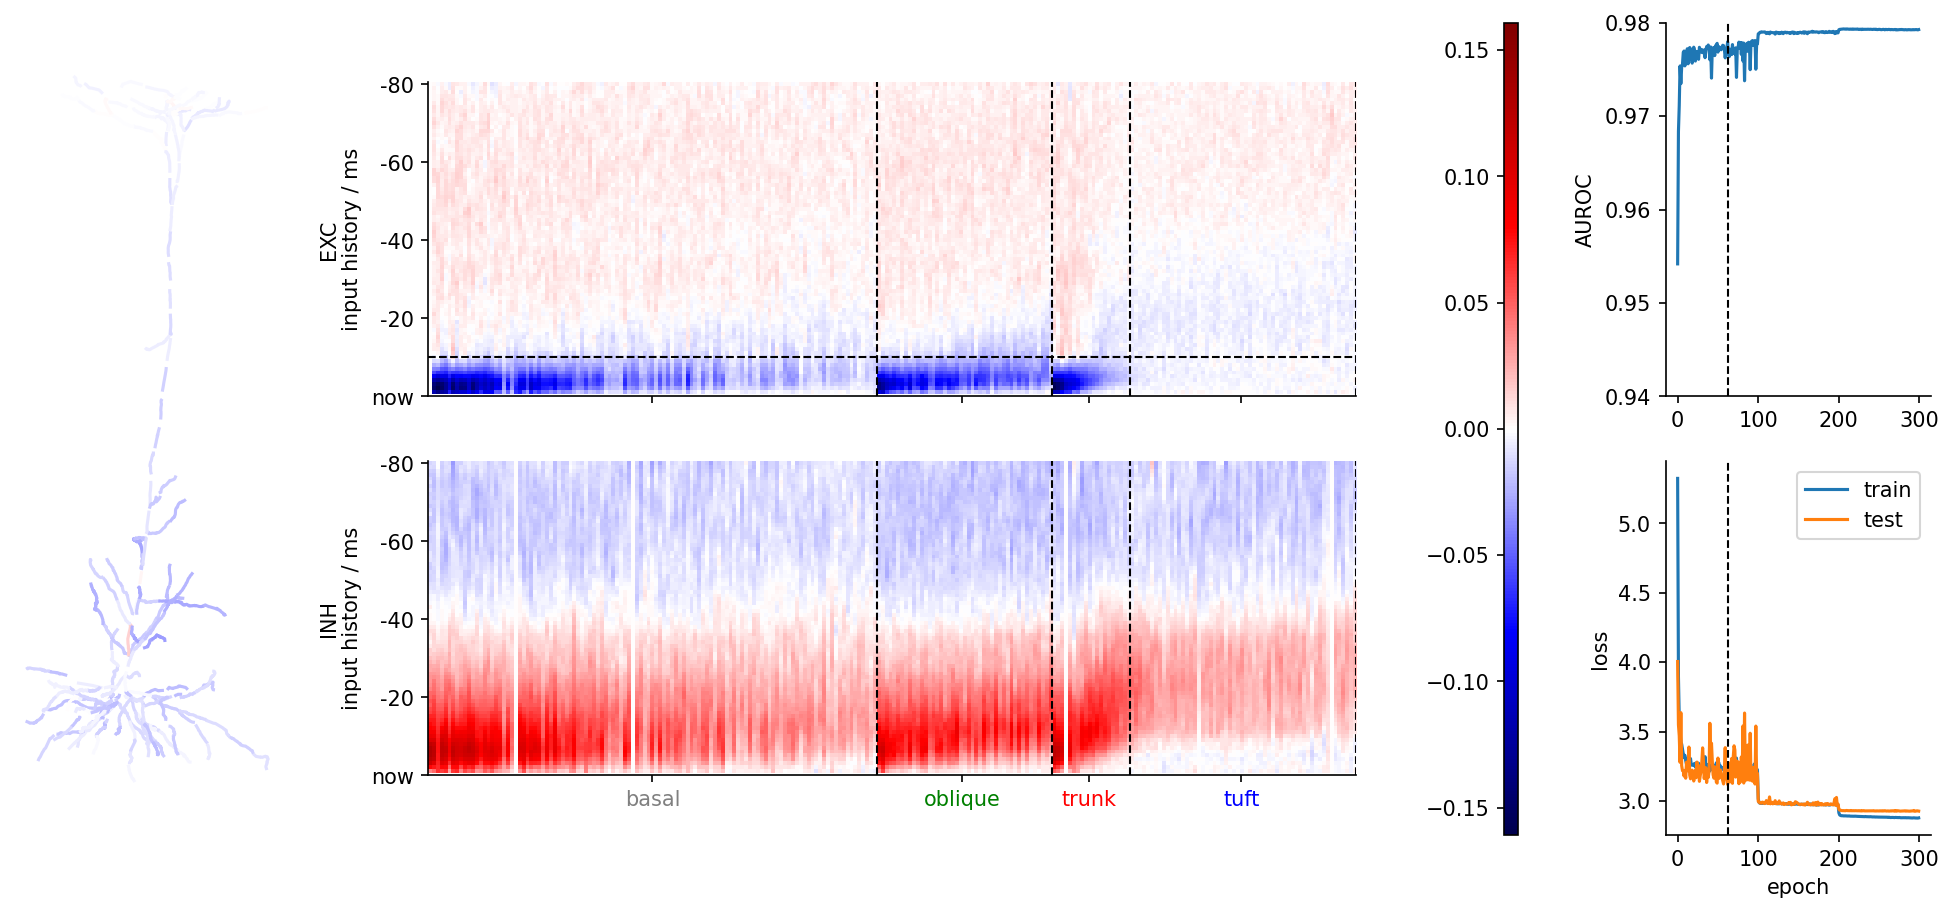

In [61]:
epoch = 64
t=79

WP = WeightPlot(neuron_param_file, mdb_models_arco, model_arco)
I.plt.figure(figsize = (10,5))
axes = WP.plot_weights(**weight_reshape_params, categories=False, celltype=celltype, t=t, epoch=epoch)
I.plt.show()

## Arco's model: automatically selected best epoch (207)

Building cell from neuron parameter file


<Figure size 720x360 with 0 Axes>

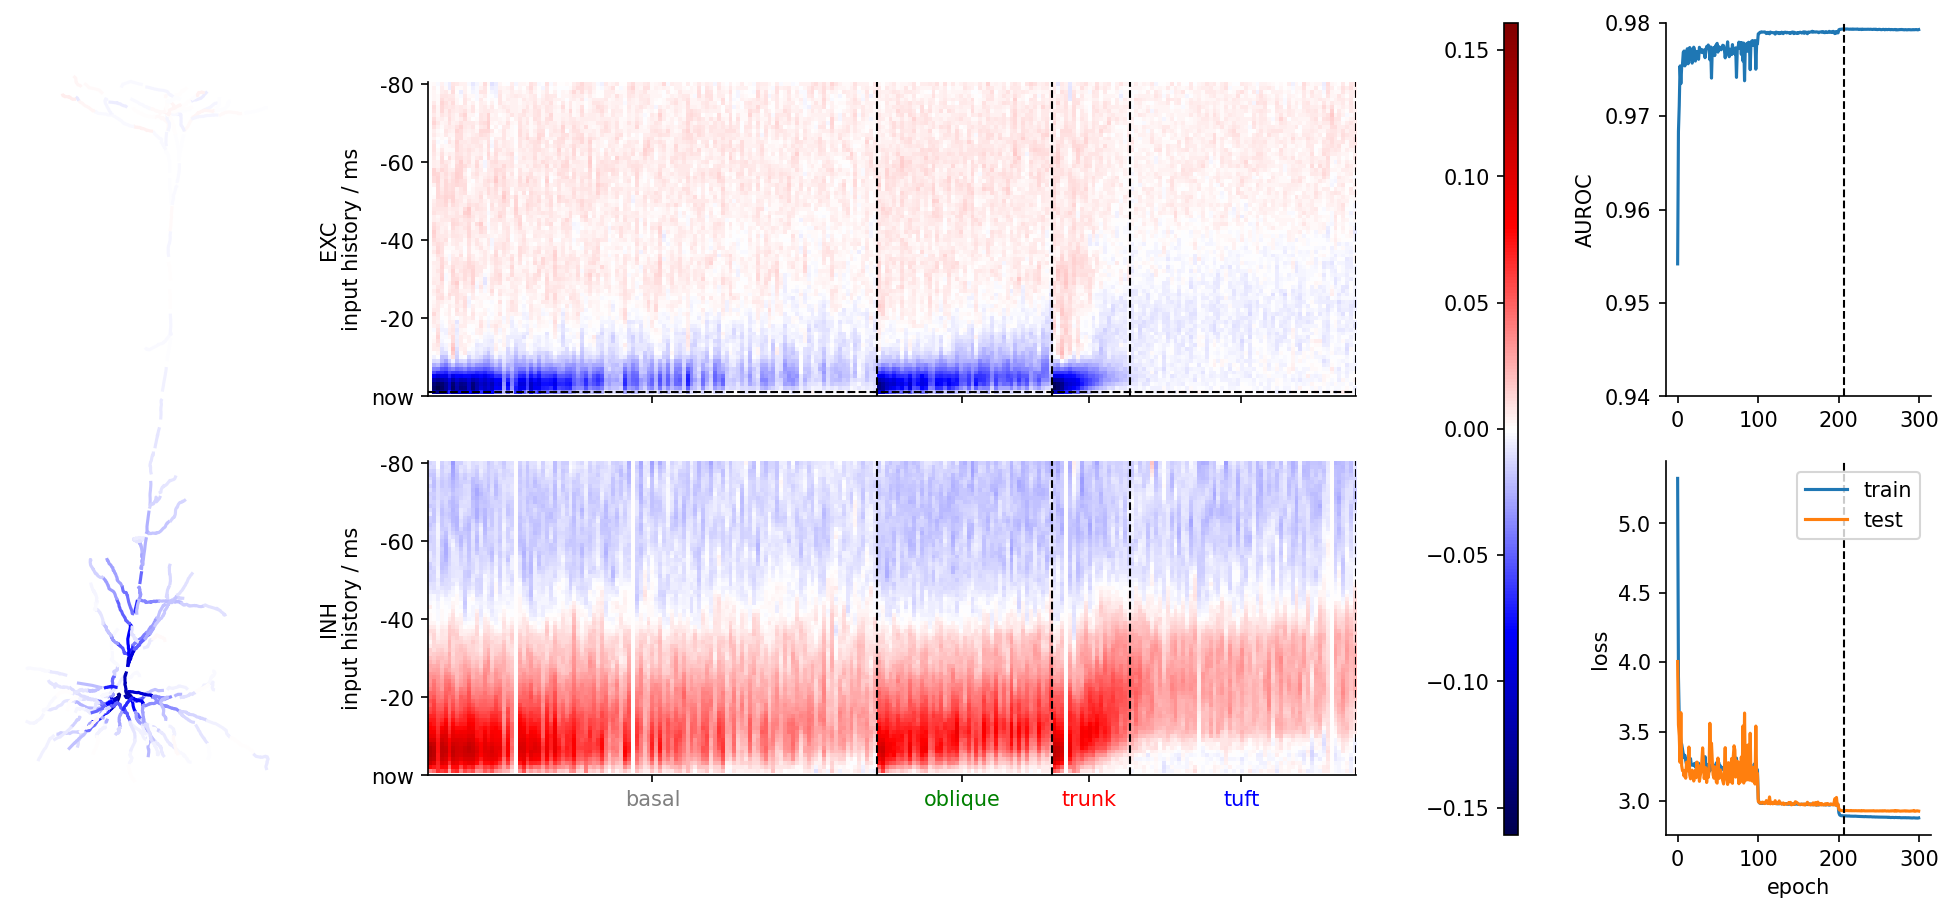

In [94]:
bottleneck_node = 0
I.plt.figure(figsize = (10,5))
WP = WeightPlot(neuron_param_file, mdb_models_arco, model_arco, bottleneck_node=bottleneck_node)
axes = WP.plot_weights(**weight_reshape_params, categories=False, celltype=celltype, t=79)
I.plt.show()

## Making a video of these plots that scrolls through time

In [66]:
# make a video
mdb_out = I.ModelDataBase('/gpfs/soma_fs/scratch/meulemeester/results/bottleneck')
outdir = mdb_out.create_managed_folder('figures', raise_ = False)  # if not yet created

for t in data_helper_functions.tqdm(range(80)):
    WP.save_plot_of_weights_at_t(t, **weight_reshape_params, celltype=celltype, outdir=outdir)

100%|██████████| 80/80 [01:19<00:00,  1.00it/s]


# Visualizing the decoder network

Having a good grasp of the encoder that sums synaptic input, it is now time to ask ourselves: what is the decoder then doing? This section concerns itself with visualizing all the inputs the decoder is receiving.

These inputs are:
- The aggregated synaptic input (as visualised above). Can be either 1 or 2. We will start with just 1 though, to keep it simple.
- dend_ISI: last time since a dentritic spike
- soma_ISI: last time since a somatic spike

In [95]:
from decoder_helper_functions import get_decoder_info

## Setup mdbs

In [85]:
mdb_models_arco = mdb['reduced_ANN_models5']
model_arco = 'loss_sAP__bn_1__ISIsd__width_min_max_80_0_60__decoder_5x40__L2_0.001_L1_0_TV_0.001__epochs_300__batches_200__ntrials_280000__traintest_260000_20000__1HOE2'
model = helper_functions.get_model(mdb_models_arco, model_arco)

mdb_out = I.ModelDataBase('/gpfs/soma_fs/scratch/meulemeester/results/bottleneck')

# Check model
model.to('cpu')

Model(
  (relu): ReLU()
  (linear1): Linear(in_features=41600, out_features=1, bias=False)
  (bottleneck_layer): Linear(in_features=3, out_features=40, bias=True)
  (layer_asd_0): Linear(in_features=40, out_features=40, bias=True)
  (layer_asd_1): Linear(in_features=40, out_features=40, bias=True)
  (layer_asd_2): Linear(in_features=40, out_features=40, bias=True)
  (layer_asd_3): Linear(in_features=40, out_features=40, bias=True)
  (layer_asd_4): Linear(in_features=40, out_features=40, bias=True)
  (output_layer): Linear(in_features=40, out_features=1, bias=True)
)

In [77]:
# Loading data
batch_range = 10  # all batches: 560 (takes some time)
SA, ISI_SOMA, AP_SOMA, VT_SOMA, ISI_DEND, AP_DEND, VT_DEND = data_helper_functions.load_data_uncached(batches_dir, batch_range=batch_range)
decoder_params = {
    "AP_SOMA": AP_SOMA,
    "AP_DEND": AP_DEND,
    "ISI_SOMA": ISI_SOMA,
    "ISI_DEND": ISI_DEND,
    "VT_SOMA": VT_SOMA,
    "VT_DEND": VT_DEND,
    "SA": SA,
    "temporal_window_width": 80
}

Loading batches: 100%|██████████| 10/10 [00:00<00:00, 30817.81it/s]


In [79]:
# parse data: feed it through forward() function
soma_isi, dend_isi, bottleneck_out, model_out = get_decoder_info(**decoder_params, model=model)

Sliding 80 ms wide time window from 0 to 60: 100%|██████████| 60/60 [00:02<00:00, 23.99it/s]


## Parsing the data

Let's create a 4D dataframe that has somatic inter-spike interval (ISI), dendritic ISI, the total weighted synaptic input that's being summed to the bottleneck, and the eventual model output prediciton

In [86]:
# Create a 4d dataframe to scrobble through
df = I.pd.DataFrame.from_dict({"soma_isi": soma_isi[:,0], "bottleneck_node": -1*bottleneck_out[:,0], 
"dend_isi": dend_isi[:,0], "model_output": model_out[:,0]})
# dend_isi needs to be substracted by 100ms due to some error in previous code that generated this data
mdb_out["4d-data"] = df

start deleting /gpfs/soma_fs/scratch/meulemeester/results/bottleneck/4d-data_orhilhav_
done deleting /gpfs/soma_fs/scratch/meulemeester/results/bottleneck/4d-data_orhilhav_


## Plotting the training data

In [90]:
import Interface as I
import viz
# loading the data. This is re-defined in this cell in case the kernel dies inbetween, so you don't have to re-process the data
mdb_out = I.ModelDataBase('/gpfs/soma_fs/scratch/meulemeester/results/bottleneck')
df = mdb_out["4d-data"]
outdir = mdb_out.create_managed_folder('figures', raise_ = False)  # if not yet created
ax_lim=(0,300)  # limits for dend_isi and soma_isi in ms

mn, mx = -10, 15  # min and max weighted somatic drive: -10 and 15
stepsize=.2  # .2 is smooth

client.compute(
    [
    viz.write_frame_at_synaptic_input(model, weighted_input, df, outdir, stepsize, show=False) 
    for weighted_input in I.np.arange(mn, mx, step=stepsize)
    ])

# you can use these frames to make a video with ffmpeg

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## Training data vs model predictions

Plot all possible inputs to the decoder, but also keep track of which of these inputs are novel compared to the training data.

This visualisation plots out all possible inputs the decoder may receive, and overlays it with the actual training data, so you can see how realistic some predictions are, and which predicitons are pure extrapolation

In [92]:
import Interface as I
mdb_out = I.ModelDataBase('/gpfs/soma_fs/scratch/meulemeester/results/bottleneck')
df = mdb_out["4d-data"]
ax_lim = (0, 300)
outdir = mdb_out.create_managed_folder('figures', raise_ = False)  # if not yet created


mn, mx = -10, 15  # min and max synaptic input values
stepsize=.2
# upload modules needed to dask workers
client.upload_file("/gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/project_specific_ipynb_code/bottleneck_project/decoder_helper_functions.py")
client.compute(
[
    viz.write_overlay_frame(weighted_input, stepsize) for weighted_input in I.np.arange(mn, mx, step=stepsize)
]
)

[<Future: pending, key: write_overlay_frame-27cc9901-35ef-450c-961c-d366177fc533>,
 <Future: pending, key: write_overlay_frame-fa175086-0f89-498c-94cb-04254ee7541f>,
 <Future: pending, key: write_overlay_frame-f6eb5b38-1145-4e3e-a80f-ef6ed7514c10>,
 <Future: pending, key: write_overlay_frame-088d1993-96df-4825-9c4a-404d5d7ae17c>,
 <Future: pending, key: write_overlay_frame-a030adf9-ec22-4221-8813-a21c18bd2845>,
 <Future: pending, key: write_overlay_frame-b358f489-c681-46a1-bb38-78ca142631ba>,
 <Future: pending, key: write_overlay_frame-b965f066-46d3-4624-953e-62f99ba8e2b0>,
 <Future: pending, key: write_overlay_frame-96ecfdf9-7f18-4a02-8968-425dcdb7ec88>,
 <Future: pending, key: write_overlay_frame-dbfc489a-412a-433b-af06-81b93d06c459>,
 <Future: pending, key: write_overlay_frame-4af81ef2-b512-467b-b948-601fa673b2f3>,
 <Future: pending, key: write_overlay_frame-ace699c6-f4f5-48a2-9c1b-d0e6a3e20cce>,
 <Future: pending, key: write_overlay_frame-4ba2ef07-8cf7-40a7-9239-68a1c2c7a8b7>,
 <Fu